In [70]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
import pickle

## Parameters

In [71]:
path_to_data = "bank-customer-churn.csv"
target_attr = "churn"

## Load Bank Customer Churn Data Set

In [72]:
bank_churn_df = pd.read_csv(path_to_data)

bank_churn_df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [73]:
bank_churn_df.shape

(10000, 12)

In [74]:
bank_churn_df.columns

Index(['customer_id', 'credit_score', 'country', 'gender', 'age', 'tenure',
       'balance', 'products_number', 'credit_card', 'active_member',
       'estimated_salary', 'churn'],
      dtype='object')

In [75]:
bank_churn_df["country"].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [76]:
bank_churn_df["products_number"].unique()

array([1, 3, 2, 4])

In [77]:
bank_churn_df.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [78]:
bank_churn_df.dtypes

customer_id           int64
credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

In [79]:
bank_churn_df[['credit_score','age', 'tenure', 'balance', 'estimated_salary']].describe()

,credit_score,age,tenure,balance,estimated_salary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,100090.239881
std,96.653299,10.487806,2.892174,62397.405202,57510.492818
min,350.000000,18.000000,0.000000,0.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,199992.480000


## EDA

/Users/jeffersoncuartas/miniconda3/envs/usml_base_ds/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jeffersoncuartas/miniconda3/envs/usml_base_ds/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jeffersoncuartas/miniconda3/envs/usml_base_ds/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jeffersoncuartas/miniconda3/envs/usml_base_ds/lib/python3.10/site-packages/sea

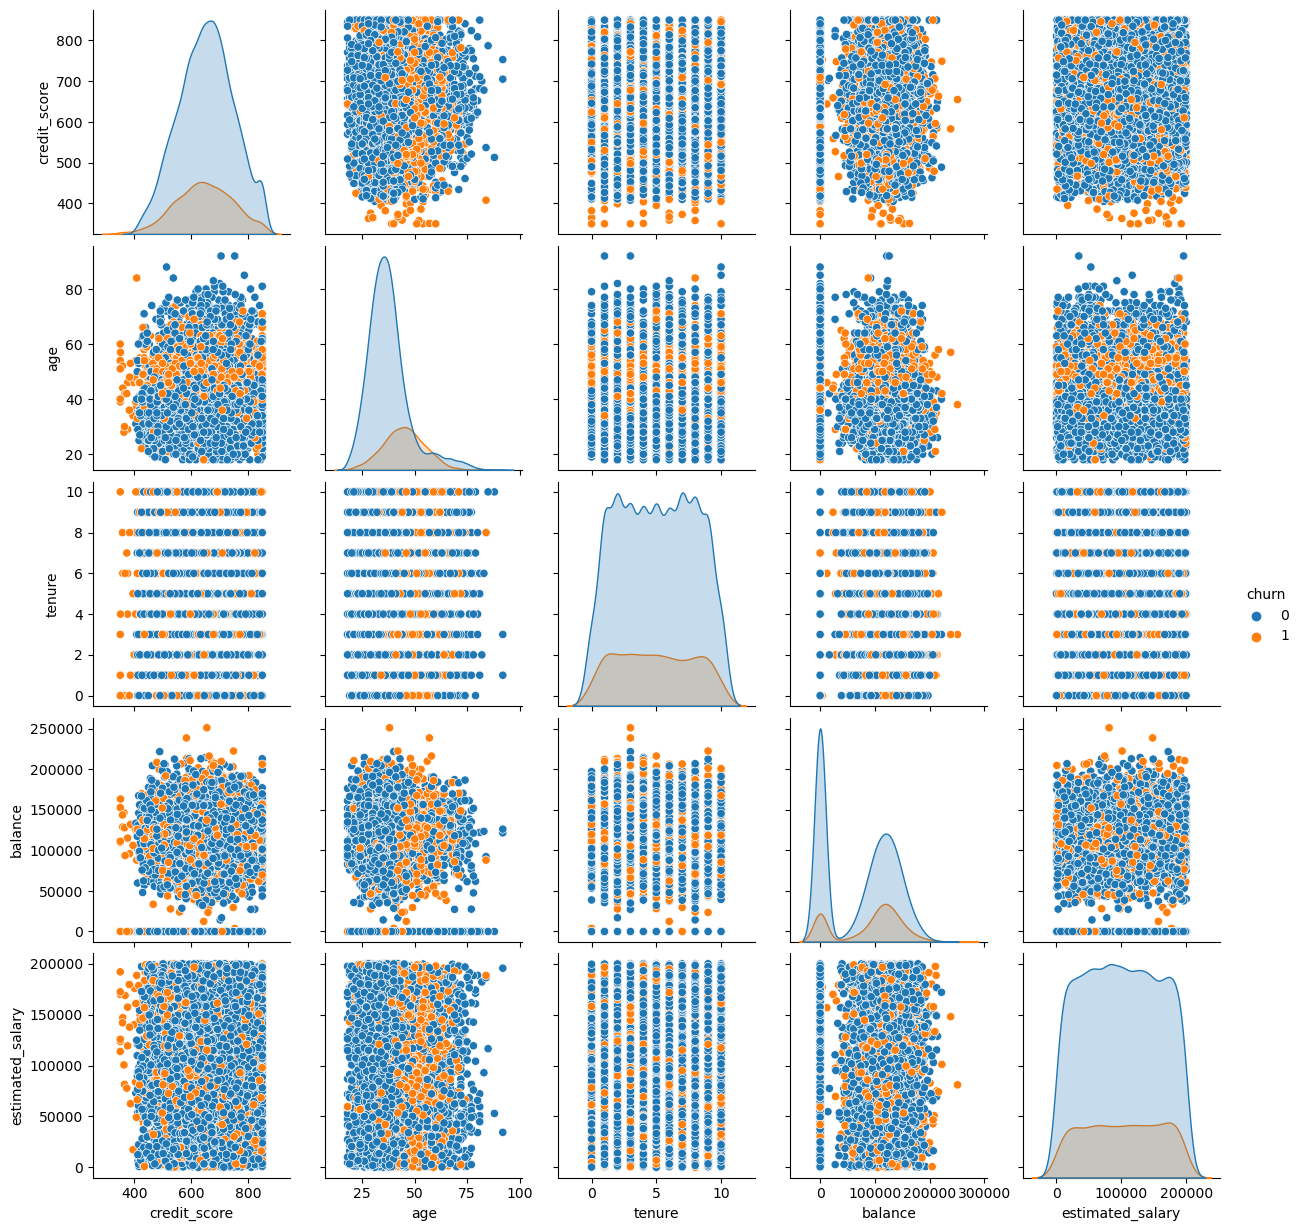

In [80]:
# Pairwise Plots
examine_cols = ['credit_score','age', 'tenure', 'balance', 'estimated_salary', 'churn']
sns.pairplot(bank_churn_df[examine_cols], hue="churn")
plt.show()

In [81]:
## Findings

"""
- credit score distribution for those who churn vs not are similar
- age distribution of those who churn indicate that older individuals more likely to churn
- tenure distribution of those who churn vs not are similar

- age seems to biggest predictor of whether someone will churn or not (40 - 70 age group at risk for churning)

"""

'\n- credit score distribution for those who churn vs not are similar\n- age distribution of those who churn indicate that older individuals more likely to churn\n- tenure distribution of those who churn vs not are similar\n\n- age seems to biggest predictor of whether someone will churn or not (40 - 70 age group at risk for churning)\n\n'

In [82]:
# sns.heatmap(bank_churn_df[examine_cols].corr(), annot=True)

## Random Forest Model

In [83]:
bank_churn_df["gender_code"] = bank_churn_df["gender"].astype("category").cat.codes

In [84]:
bank_churn_df

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,gender_code
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,0
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,France,Male,39,5,0.00,2,1,0,96270.64,0,1
9996,15569892,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,1
9997,15584532,709,France,Female,36,7,0.00,1,0,1,42085.58,1,0
9998,15682355,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,1


In [85]:
predictors = ['gender_code','credit_score','age', 'tenure', 'balance', 'estimated_salary']

In [86]:
# split dataset into 70 % training dataset and 30 % test datasets
testing = bank_churn_df.sample(frac = 0.3, random_state = 42)
training = bank_churn_df.drop(testing.index)

In [87]:
# create a RF classifier
rf = RandomForestClassifier(n_estimators = 100, min_samples_split=10, random_state=1)

rf.fit(training[predictors], training[target_attr])

# performing predictions on the test dataset
preds = rf.predict(testing[predictors])

## Accuracy of Model

In [88]:
acc = accuracy_score(testing[target_attr], preds)
acc

0.8133333333333334

In [89]:
# examine accuracy
combined = pd.DataFrame(dict(actual=testing[target_attr], prediction=preds))

In [90]:
# confusion matrix
pd.crosstab(index=combined["actual"], columns=combined["prediction"])

prediction,0,1
actual,,
0,2284,132
1,428,156


In [91]:
precision_score(testing[target_attr], preds)

0.5416666666666666

## Improve Machine Learning Model

In [92]:
add_predictors = ['gender_code','credit_score','age', 'tenure', 'balance', 'estimated_salary', 'credit_card', "products_number"]

In [93]:
# split dataset into 70 % training dataset and 30 % test datasets
testing_B = bank_churn_df.sample(frac = 0.3, random_state = 42)
training_B = bank_churn_df.drop(testing.index)

In [94]:
# create a RF classifier
rf_B = RandomForestClassifier(n_estimators = 100, min_samples_split=10, random_state=1)

rf_B.fit(training_B[add_predictors], training_B[target_attr])

# performing predictions on the test dataset
preds_B = rf_B.predict(testing_B[add_predictors])

In [95]:
acc_B = accuracy_score(testing_B[target_attr], preds_B)
acc

0.8133333333333334

In [96]:
precision_score(testing_B[target_attr], preds_B)

0.6996904024767802

## Hyperparameter Tuning

In [97]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf_C = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf_C, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(training_B[add_predictors], training_B[target_attr])

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1762d8fd0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16c162ec0>})

In [98]:
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 14, 'n_estimators': 256}


In [99]:
preds_C = best_rf.predict(testing_B[add_predictors])

In [100]:
acc_C = accuracy_score(testing_B[target_attr], preds_C)
acc

0.8133333333333334

In [101]:
precision_score(testing_B[target_attr], preds_C)

0.7175324675324676

## Save Machine Learning Model

In [102]:
pickle.dump(best_rf, open('model.pkl','wb')) 

## Test Model with Sample User Input

In [103]:
user_data = {'gender_code': 0,'credit_score': 350,'age': 25, 'tenure': 2, 'balance': 97198.54, 'estimated_salary': 51002.11, 'credit_card': 1, "products_number": 1}
user_df = pd.DataFrame([user_data])

user_prediction = best_rf.predict(user_df)
user_prediction

array([1])